# Evaluation of the 3 datasets with ML

In [1]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression   
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return ' '.join(word for word in lemmatized)

def plot_learning_curve(model, Name, X_train, y_train):

    train_sizes = np.linspace(0.1, 1, 15)
    
    train_sizes, train_scores, test_scores = learning_curve(
                  model, X_train, y_train, 
                  train_sizes = train_sizes,
                  cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title(f"Model - {Name}")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "CV Test score")
    plt.legend(loc="best")
    plt.show()


def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)

def get_scores(model, model_name, X_train, y_train, X_test, y_test):
    
    # Cross Validation
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring = scoring)

    acc = cv_results['test_accuracy'].mean()
    recall = cv_results['test_recall'].mean()
    precision = cv_results['test_precision'].mean()
    f1 = cv_results['test_f1'].mean()
    
    print('-'*80)
    print(f"{model_name} - CV scores: ")
    print('-'*80)
    print(f"Acc : {acc:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"f1: {f1:.2f}")
    
    # Test evaluation
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print('-'*80)
    print(f"{model_name} - test scores: ")
    binary_metrics(y_test, y_preds)
    
    return acc, recall, precision, f1

def save_model(model, model_name = 'model.joblib'):
    """
    Save the model into a .joblib format
    """
    joblib.dump(model, model_name)
    print(colored('-'*80, 'green'))
    print(colored(f"{model_name} saved locally", "green"))
    print(colored('-'*80, 'green'))

def get_model(path_to_joblib):
    """
    Upload the model
    """
    pipeline = joblib.load(path_to_joblib)
    return pipeline

## Loading Datasets

### Loading `politifact_scrap.csv`

In [3]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [4]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: washington public school force unvaccinated teen wear ankle monitor condition playing team sport
--------------------------------------------------------------------------------


In [5]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


### Loading `FakeNewsNET`

In [6]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [7]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: djou win special election congress
--------------------------------------------------------------------------------


In [8]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [9]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [10]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [11]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [12]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: u budget fight loom republican flip fiscal script
--------------------------------------------------------------------------------


In [13]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


### Loading `Poynter`

In [14]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/stopfaike_eddy/data/poynter_final_condensed.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_PO = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_PO shape: {data_PO.shape}")
print('-'*80)
print('-'*80)
print(data_PO['label_list_transformed'].value_counts()/len(data_PO)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_PO shape: (14897, 3)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0    50.063771
1.0    49.936229
Name: label_list_transformed, dtype: float64
--------------------------------------------------------------------------------


In [15]:
data_PO.head()

,Unnamed: 0,title_list,label_list_transformed
0,0,There is a call for free vaccination in the Ci...,1.0
1,1,Video of a girl being forcibly vaccinated agai...,1.0
2,2,The US CDC has admitted an error in the PCR te...,1.0
3,3,Children are 50 times more likely to die from ...,1.0
4,4,Those vaccinated against the COVID-19 cannot d...,1.0


In [16]:
X_PO = data_PO['title_list'].apply(clean).copy()
y_PO = data_PO['label_list_transformed'].copy()

print('-'*80)
print(f"X_PO shape: {X_PO.shape}")
print(f"y_PO shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_PO['title_list'][0]}")
print(f"Clean text: {X_PO[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO shape: (14897,)
y_PO shape: (19826,)
--------------------------------------------------------------------------------
Original text: There is a call for free vaccination in the Ciudad de la Luz center, in Alicante, for people over 12 years old.
Clean text: call free vaccination ciudad de la luz center alicante people year old
--------------------------------------------------------------------------------


In [17]:
X_PO_train, X_PO_test, y_PO_train, y_PO_test = train_test_split(X_PO, y_PO, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_PO_train shape: {X_PO_train.shape}")
print(f"y_PO_train shape: {y_PO_train.shape}")
print('-'*80)
print(f"X_PO_test shape: {X_PO_test.shape}")
print(f"y_PO_test shape: {y_PO_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_PO_train.sum()/len(y_PO_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_PO_test.sum()/len(y_PO_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train shape: (11917,)
y_PO_train shape: (11917,)
--------------------------------------------------------------------------------
X_PO_test shape: (2980,)
y_PO_test shape: (2980,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 49.870
Fake (1) proportion in test (%): 50.201
--------------------------------------------------------------------------------


### Merging `All`

In [18]:
X_all = pd.concat([X_P, X_FNN, X_BIS]).reset_index(drop=True)
y_all = pd.concat([y_P, y_FNN, y_BIS]).reset_index(drop=True)

print('-'*80)
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_all shape: (83796,)
y_all shape: (83796,)
--------------------------------------------------------------------------------


In [19]:
X_ALL_train, X_ALL_test, y_ALL_train, y_ALL_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_ALL_train shape: {X_ALL_train.shape}")
print(f"y_ALL_train shape: {y_ALL_train.shape}")
print('-'*80)
print(f"X_ALL_test shape: {X_ALL_test.shape}")
print(f"y_ALL_test shape: {y_ALL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALL_train.sum()/len(y_ALL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALL_test.sum()/len(y_ALL_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train shape: (67036,)
y_ALL_train shape: (67036,)
--------------------------------------------------------------------------------
X_ALL_test shape: (16760,)
y_ALL_test shape: (16760,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 46.453
Fake (1) proportion in test (%): 46.718
--------------------------------------------------------------------------------


#### Checking foreign characters

In [20]:
# vectorizer = TfidfVectorizer()
# X_vec = vectorizer.fit_transform(X_FNN)

# X_vec_df = pd.DataFrame(X_vec.toarray(), columns = vectorizer.get_feature_names())

# print('-'*80)
# print(f"X_vec shape: {X_train_vec.shape}")
# print('-'*80)
# print(X_vec_df.head())
# print('-'*80)

In [21]:
# data_FNN['title'].str.contains('ы').sum()

### Merging `Alll`

In [22]:
X_alll = pd.concat([X_all, X_PO]).reset_index(drop=True)
y_alll = pd.concat([y_all, y_PO]).reset_index(drop=True)

print('-'*80)
print(f"X_alll shape: {X_alll.shape}")
print(f"y_alll shape: {y_alll.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_alll shape: (98693,)
y_alll shape: (98693,)
--------------------------------------------------------------------------------


In [24]:
X_ALLL_train, X_ALLL_test, y_ALLL_train, y_ALLL_test = train_test_split(X_alll, y_alll, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_ALLL_train shape: {X_ALLL_train.shape}")
print(f"y_ALLL_train shape: {y_ALLL_train.shape}")
print('-'*80)
print(f"X_ALLL_test shape: {X_ALLL_test.shape}")
print(f"y_ALLL_test shape: {y_ALLL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALLL_train.sum()/len(y_ALLL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALLL_test.sum()/len(y_ALLL_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train shape: (78954,)
y_ALLL_train shape: (78954,)
--------------------------------------------------------------------------------
X_ALLL_test shape: (19739,)
y_ALLL_test shape: (19739,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 47.031
Fake (1) proportion in test (%): 46.993
--------------------------------------------------------------------------------


## `politifact_scrap.csv`

### Preprocessing

In [25]:
vectorizer_P = TfidfVectorizer()
X_P_train_vec = vectorizer_P.fit_transform(X_P_train)
X_P_test_vec = vectorizer_P.transform(X_P_test)

X_P_train_vec_df = pd.DataFrame(X_P_train_vec.toarray(), columns = vectorizer_P.get_feature_names())

print('-'*80)
print(f"X_P_train_vec shape: {X_P_train_vec.shape}")
print(f"X_P_test_vec shape: {X_P_test_vec.shape}")
print('-'*80)
print(X_P_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_vec shape: (15860, 12692)
X_P_test_vec shape: (3966, 12692)
--------------------------------------------------------------------------------
    aa  aaa  aaron  aarp   ab  aba  abaco  abandoned  abbas  abbott  ...  \
0  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
1  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
2  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
3  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   
4  0.0  0.0    0.0   0.0  0.0  0.0    0.0        0.0    0.0     0.0  ...   

   zoning  zoo  zoom  zpass  zuber  zucker  zuckerberg  zyphr  único  ḍozen  
0     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
1     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
2     0.0  0.0   0.0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  

### Logistic Regression

--------------------------------------------------------------------------------
Logistic Reg - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.73
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------
Logistic Reg - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.72
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------


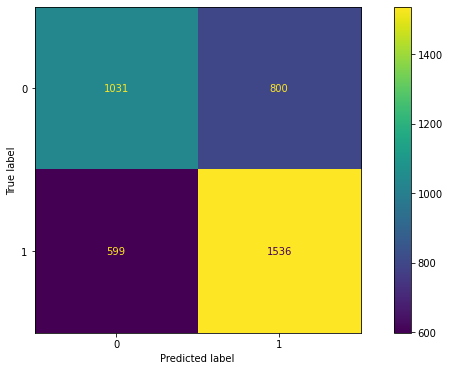

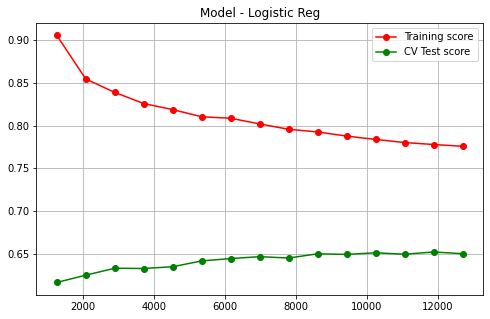

In [26]:
log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
acc, recall, precision, f1 = get_scores(log_model, 'Logistic Reg', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

plot_confusion_matrix(log_model, X_P_test_vec, y_P_test, values_format='d');

plot_learning_curve(log_model, 'Logistic Reg', X_P_train_vec, y_P_train)

### Logistic Regression - Fine-Tuning

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log_reg', LogisticRegression(max_iter=1000)),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'log_reg__C': (0.01, 0.1, 1, 10)
}

lg_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

lg_grid_search.fit(X_P_train, y_P_train)

print('-'*80)
print(f"Best parameters: {lg_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'log_reg__C': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Log Reg - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.66
Recall: 0.68
Precision: 0.69
f1: 0.69
--------------------------------------------------------------------------------
Log Reg - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.68
Precision: 0.69
f1: 0.68
--------------------------------------------------------------------------------


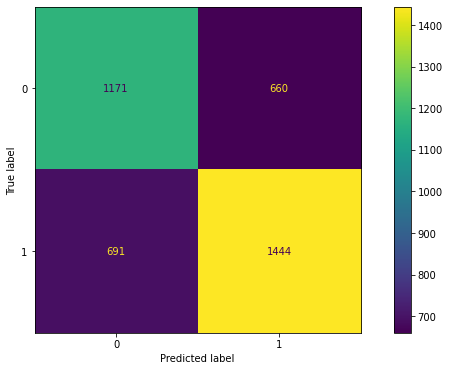

In [28]:
acc, recall, precision, f1 = get_scores(lg_grid_search.best_estimator_, 'Log Reg - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(lg_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.70
Precision: 0.67
f1: 0.69
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.69
Precision: 0.67
f1: 0.68
--------------------------------------------------------------------------------


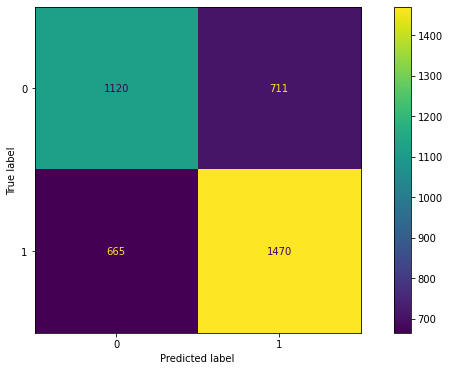

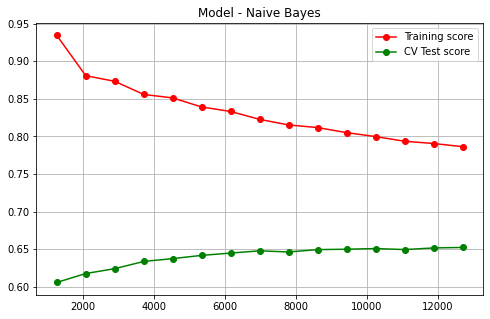

In [29]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

plot_confusion_matrix(nb_model, X_P_test_vec, y_P_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train)

### Naive Bayes - Fine-Tuning

In [30]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_P_train, y_P_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


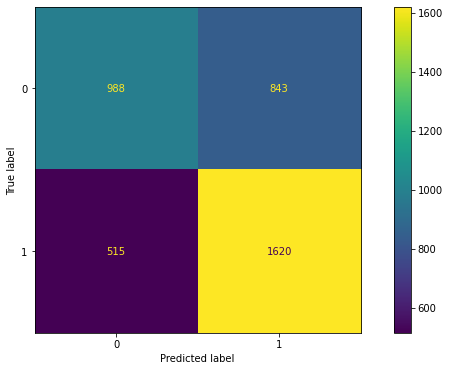

In [31]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### SVM

In [ ]:
# svm_model = SVC()
# acc, recall, precision, f1 = get_scores(svm_model, 'SVM', X_train_vec, y_train, X_test_vec, y_test)

# plot_confusion_matrix(svm_model, X_test_vec, y_test, values_format='d');

# # plot_learning_curve(svm_model, 'SVM', X_train_vec, y_train)

### Random Forest

In [ ]:
# forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
# acc, recall, precision, f1 = get_scores(forest_model, 'RandomForest', X_train_vec, y_train, X_test_vec, y_test)

# plot_confusion_matrix(forest_model, X_test_vec, y_test, values_format='d');

# # plot_learning_curve(forest_model, 'RandomForest', X_train_vec, y_train)

### Saving the model

In [32]:
model_name = '../raw_data/P_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/P_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [33]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


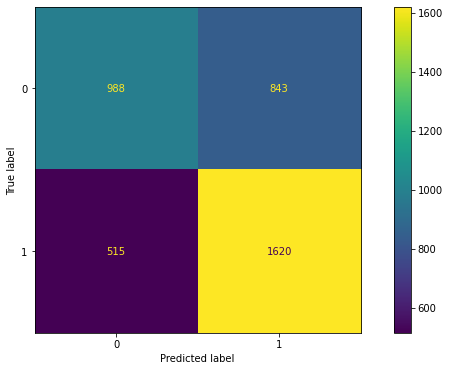

In [34]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `P_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/P_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.29
Recall: 0.94
Precision: 0.25
f1: 0.39
--------------------------------------------------------------------------------


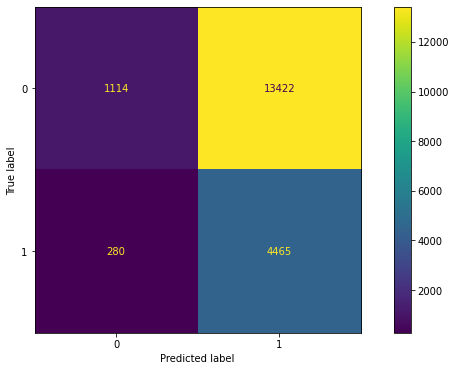

In [38]:
model_name = '../raw_data/P_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_FNN)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN, y_preds)

plot_confusion_matrix(model, X_FNN, y_FNN, values_format='d');

### `P_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/P_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.56
Recall: 0.97
Precision: 0.55
f1: 0.70
--------------------------------------------------------------------------------


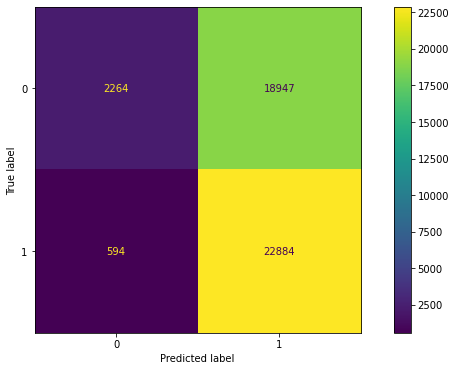

In [39]:
model_name = '../raw_data/P_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_BIS)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS, y_preds)

plot_confusion_matrix(model, X_BIS, y_BIS, values_format='d');

## `FakeNewsNET`

### Preprocessing

In [40]:
vectorizer_F = TfidfVectorizer()
X_FNN_train_vec = vectorizer_F.fit_transform(X_FNN_train)
X_FNN_test_vec = vectorizer_F.transform(X_FNN_test)

X_FNN_train_vec_df = pd.DataFrame(X_FNN_train_vec.toarray(), columns = vectorizer_F.get_feature_names())

print('-'*80)
print(f"X_FNN_train_vec shape: {X_FNN_train_vec.shape}")
print(f"X_FNN_test_vec shape: {X_FNN_test_vec.shape}")
print('-'*80)
print(X_FNN_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_vec shape: (15424, 12773)
X_FNN_test_vec shape: (3857, 12773)
--------------------------------------------------------------------------------
   aaliyah  aaron   ab  abandon  abasolo  abba  abbey  abbi  abbie  abbott  \
0      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
1      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
2      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
3      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
4      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   

   ...  букмекерская  вин  контора  монако  пернелл  питт  принцессы  ради  \
0  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
1  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
2  ...           0.0  0.0      0.0     0.0      0.0   0.0    

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.80
Recall: 0.25
Precision: 0.84
f1: 0.39
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.29
Precision: 0.81
f1: 0.43
--------------------------------------------------------------------------------


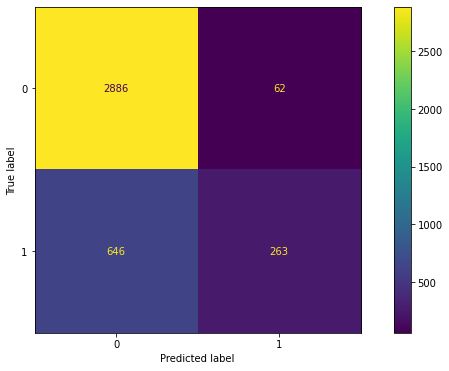

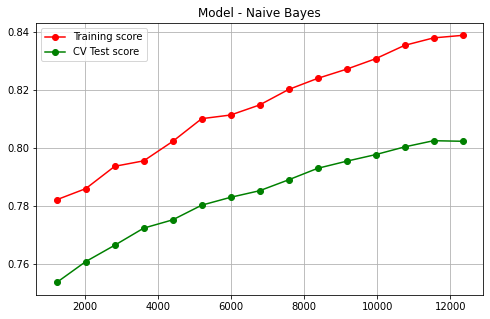

In [41]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train, X_FNN_test_vec, y_FNN_test)

plot_confusion_matrix(nb_model, X_FNN_test_vec, y_FNN_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train)

### Naives Bayes - Fine Tuning

In [42]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_FNN_train, y_FNN_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.45
Precision: 0.72
f1: 0.55
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.49
Precision: 0.71
f1: 0.58
--------------------------------------------------------------------------------


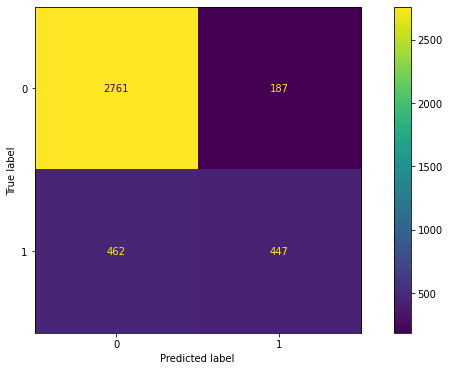

In [43]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_FNN_train, y_FNN_train, X_FNN_test, y_FNN_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_FNN_test, y_FNN_test, values_format='d');

### Saving the model

In [44]:
model_name = '../raw_data/F_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/F_model.joblib saved locally
--------------------------------------------------------------------------------


### Upload the model

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.45
Precision: 0.72
f1: 0.55
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.49
Precision: 0.71
f1: 0.58
--------------------------------------------------------------------------------


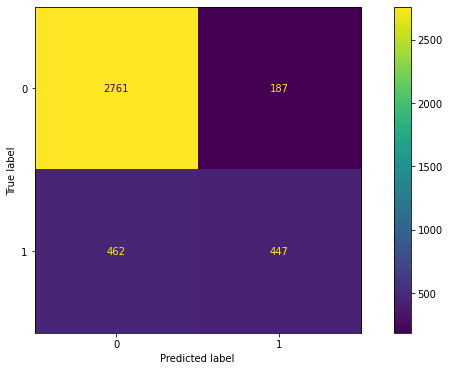

In [45]:
model = get_model(model_name)

acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_FNN_train, y_FNN_train, X_FNN_test, y_FNN_test)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `F_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/F_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.50
Recall: 0.24
Precision: 0.56
f1: 0.33
--------------------------------------------------------------------------------


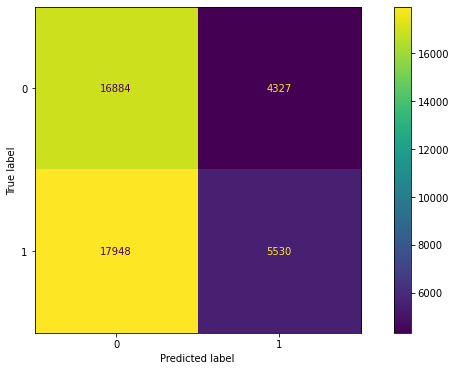

In [46]:
model_name = '../raw_data/F_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_BIS)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS, y_preds)

plot_confusion_matrix(model, X_BIS, y_BIS, values_format='d');

### `F_model.joblib` evaluation on  `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/F_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.50
Recall: 0.15
Precision: 0.70
f1: 0.24
--------------------------------------------------------------------------------


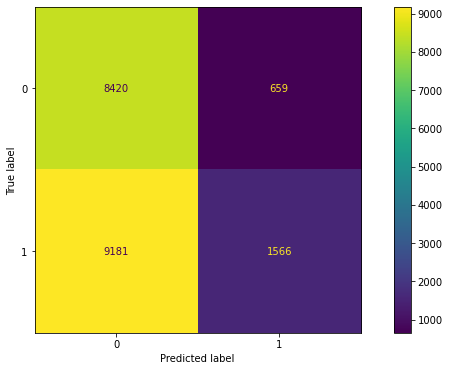

In [47]:
model_name = '../raw_data/F_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_P)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P, y_preds)

plot_confusion_matrix(model, X_P, y_P, values_format='d');

## `Bisaillon`

### Preprocessing

In [48]:
vectorizer_B = TfidfVectorizer()
X_BIS_train_vec = vectorizer_B.fit_transform(X_BIS_train)
X_BIS_test_vec = vectorizer_B.transform(X_BIS_test)

X_BIS_train_vec_df = pd.DataFrame(X_BIS_train_vec.toarray(), columns = vectorizer_B.get_feature_names())

print('-'*80)
print(f"X_BIS_train_vec shape: {X_BIS_train_vec.shape}")
print(f"X_BIS_test_vec shape: {X_BIS_test_vec.shape}")
print('-'*80)
print(X_BIS_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_vec shape: (35751, 16430)
X_BIS_test_vec shape: (8938, 16430)
--------------------------------------------------------------------------------
    aa  aar  aardvark  aaron  aarp  abadi  abandon  abandoned  abandoning  \
0  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
1  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
2  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
3  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
4  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   

   abbas  ...  zor  zschaepe  zucker  zuckerberg  zulia  zuma  zummar  zurich  \
0    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
1    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
2    0.0  ...  0.0       0.0     0.0         0.0    0.0   

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.93
Recall: 0.95
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.94
Recall: 0.96
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------


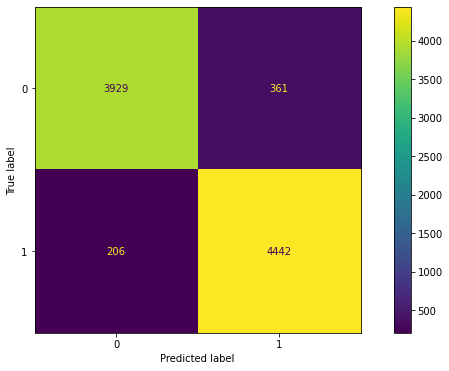

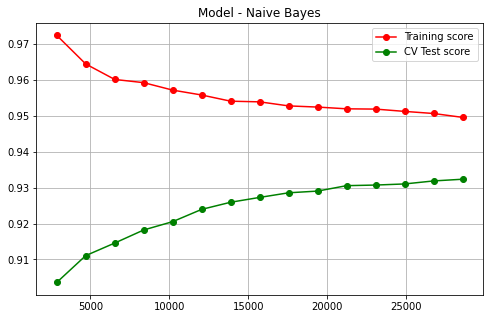

In [49]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train, X_BIS_test_vec, y_BIS_test)

plot_confusion_matrix(nb_model, X_BIS_test_vec, y_BIS_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train)

### Naive Bayes - Fine-Tuning

In [50]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_BIS_train, y_BIS_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


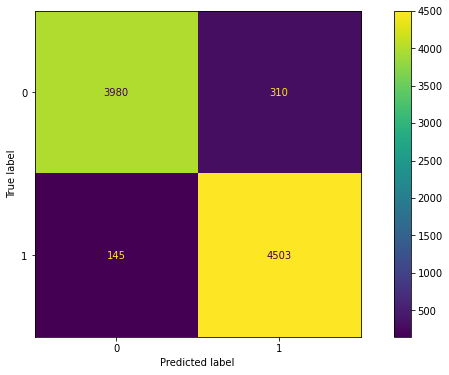

In [51]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_BIS_train, y_BIS_train, X_BIS_test, y_BIS_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_BIS_test, y_BIS_test, values_format='d');

### Saving the model

In [52]:
model_name = '../raw_data/B_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/B_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [53]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


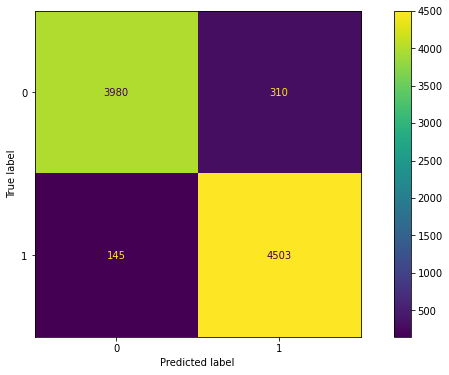

In [54]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_BIS_train, y_BIS_train, X_BIS_test, y_BIS_test)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

### `B_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/B_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.31
Recall: 0.89
Precision: 0.25
f1: 0.39
--------------------------------------------------------------------------------


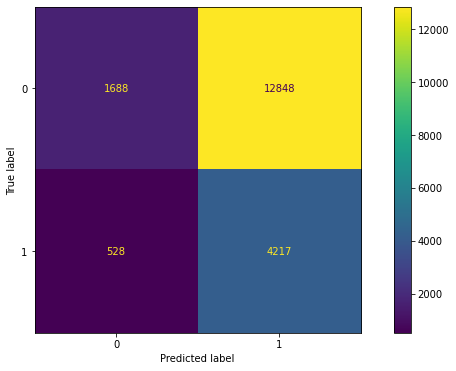

In [55]:
model_name = '../raw_data/B_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_FNN)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN, y_preds)

plot_confusion_matrix(model, X_FNN, y_FNN, values_format='d');

### `B_model.joblib` evaluation on `politifact scrap`

--------------------------------------------------------------------------------
../raw_data/B_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.56
Recall: 0.73
Precision: 0.58
f1: 0.65
--------------------------------------------------------------------------------


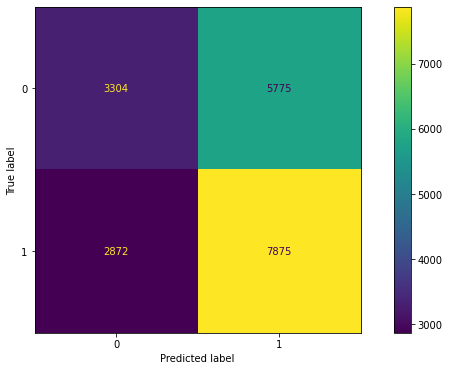

In [56]:
model_name = '../raw_data/B_model.joblib'

model = get_model(model_name)

y_preds = model.predict(X_P)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P, y_preds)

plot_confusion_matrix(model, X_P, y_P, values_format='d');

## `Poynter`

### Preprocessing

In [57]:
vectorizer_PO = TfidfVectorizer()
X_PO_train_vec = vectorizer_PO.fit_transform(X_PO_train)
X_PO_test_vec = vectorizer_PO.transform(X_PO_test)

X_PO_train_vec_df = pd.DataFrame(X_PO_train_vec.toarray(), columns = vectorizer_PO.get_feature_names())

print('-'*80)
print(f"X_PO_train_vec shape: {X_PO_train_vec.shape}")
print(f"X_PO_test_vec shape: {X_PO_test_vec.shape}")
print('-'*80)
print(X_PO_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train_vec shape: (11917, 12066)
X_PO_test_vec shape: (2980, 12066)
--------------------------------------------------------------------------------
    aa  aaj  aap  aardvark  aardvarkmobiletours  aarhus  aarogya  aaron   ab  \
0  0.0  0.0  0.0       0.0                  0.0     0.0      0.0    0.0  0.0   
1  0.0  0.0  0.0       0.0                  0.0     0.0      0.0    0.0  0.0   
2  0.0  0.0  0.0       0.0                  0.0     0.0      0.0    0.0  0.0   
3  0.0  0.0  0.0       0.0                  0.0     0.0      0.0    0.0  0.0   
4  0.0  0.0  0.0       0.0                  0.0     0.0      0.0    0.0  0.0   

   abandoned  ...  ángel  áñez  çetinkaya  évora  ümit  łukasz  şahin  \
0        0.0  ...    0.0   0.0        0.0    0.0   0.0     0.0    0.0   
1        0.0  ...    0.0   0.0        0.0    0.0   0.0     0.0    0.0   
2        0.0  ...    0.0   0.0        0.0    0.0   0.0     0.0    

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.78
Recall: 0.74
Precision: 0.80
f1: 0.77
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.79
Recall: 0.75
Precision: 0.81
f1: 0.78
--------------------------------------------------------------------------------


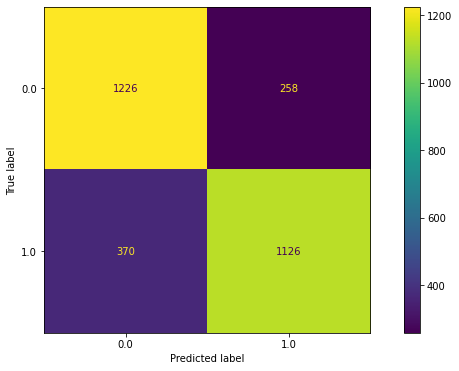

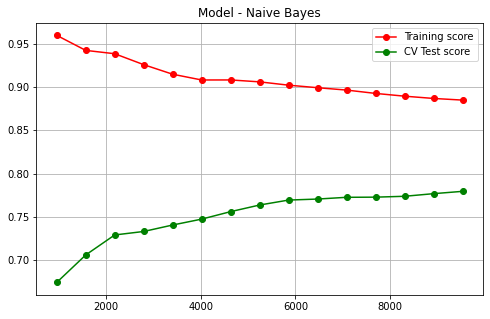

In [58]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_PO_train_vec, y_PO_train, X_PO_test_vec, y_PO_test)

plot_confusion_matrix(nb_model, X_PO_test_vec, y_PO_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_PO_train_vec, y_PO_train)

### Naive Bayes - Fine-Tuning

In [59]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_PO_train, y_PO_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Best score: 0.7906367319407324
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.79
Recall: 0.74
Precision: 0.82
f1: 0.78
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.80
Recall: 0.76
Precision: 0.83
f1: 0.79
--------------------------------------------------------------------------------


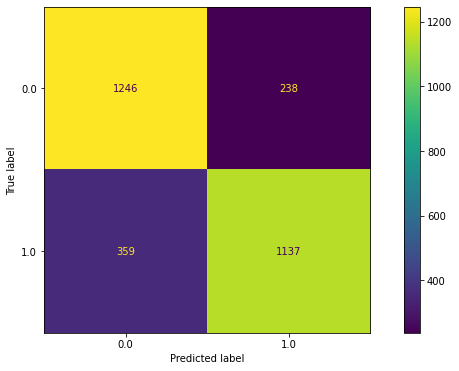

In [60]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_PO_train, y_PO_train, X_PO_test, y_PO_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_PO_test, y_PO_test, values_format='d');

### Saving the model

In [62]:
model_name = '../raw_data/PO_model.joblib'
    
save_model(nb_grid_search.best_estimator_, model_name)

model = get_model(model_name)

--------------------------------------------------------------------------------
../raw_data/PO_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [63]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.79
Recall: 0.74
Precision: 0.82
f1: 0.78
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.80
Recall: 0.76
Precision: 0.83
f1: 0.79
--------------------------------------------------------------------------------


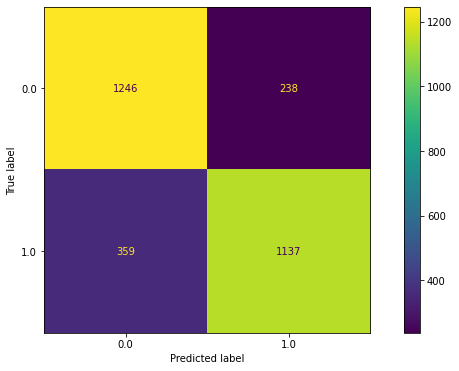

In [64]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_PO_train, y_PO_train, X_PO_test, y_PO_test)

plot_confusion_matrix(model, X_PO_test, y_PO_test, values_format='d');

### `PO_model.joblib` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/PO_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.54
Recall: 0.55
Precision: 0.58
f1: 0.56
--------------------------------------------------------------------------------


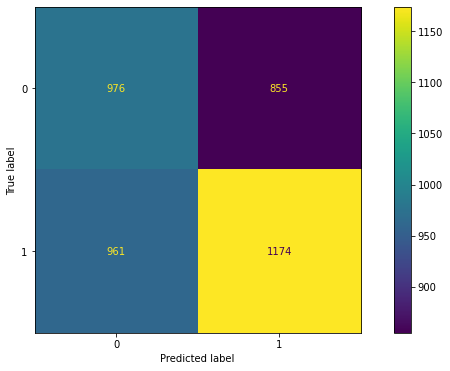

In [65]:
y_preds = model.predict(X_P_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P_test, y_preds)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `PO_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/PO_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.48
Recall: 0.51
Precision: 0.23
f1: 0.32
--------------------------------------------------------------------------------


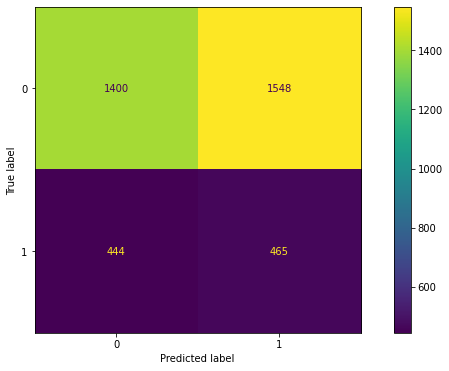

In [66]:
y_preds = model.predict(X_FNN_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN_test, y_preds)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `PO_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/PO_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.55
Recall: 0.62
Precision: 0.56
f1: 0.59
--------------------------------------------------------------------------------


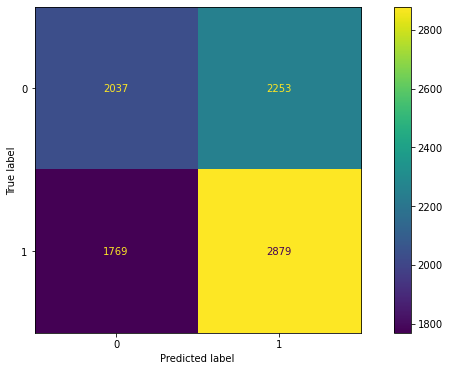

In [67]:
y_preds = model.predict(X_BIS_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS_test, y_preds)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

## `All`

### Preprocessing

In [68]:
vectorizer_ALL = TfidfVectorizer()
X_ALL_train_vec = vectorizer_ALL.fit_transform(X_ALL_train)
X_ALL_test_vec = vectorizer_ALL.transform(X_ALL_test)

X_ALL_train_vec_df = pd.DataFrame(X_ALL_train_vec.toarray(), columns = vectorizer_ALL.get_feature_names())

print('-'*80)
print(f"X_ALL_train_vec shape: {X_ALL_train_vec.shape}")
print(f"X_ALL_test_vec shape: {X_ALL_test_vec.shape}")
print('-'*80)
print(X_ALL_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train_vec shape: (67036, 25502)
X_ALL_test_vec shape: (16760, 25502)
--------------------------------------------------------------------------------
    aa  aaa  aaliyah  aar  aardvark  aaron  aarp   ab  aba  abaco  ...  вин  \
0  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
1  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
2  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
3  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   
4  0.0  0.0      0.0  0.0       0.0    0.0   0.0  0.0  0.0    0.0  ...  0.0   

   контора  монако  пернелл  питт  принцессы  ради  сми  эллу  ḍozen  
0      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
1      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
2      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
3   

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.81
Recall: 0.78
Precision: 0.81
f1: 0.80
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.78
Precision: 0.82
f1: 0.80
--------------------------------------------------------------------------------


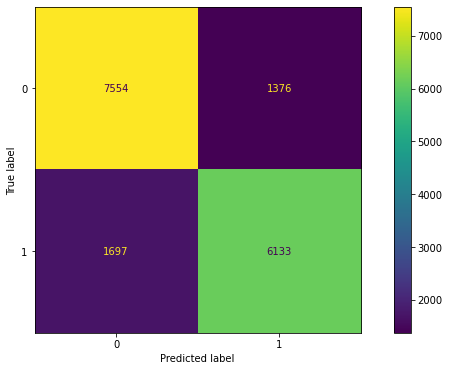

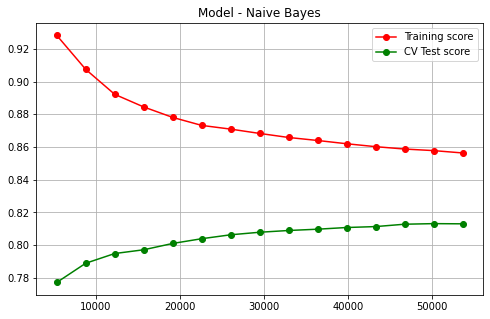

In [69]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_ALL_train_vec, y_ALL_train, X_ALL_test_vec, y_ALL_test)

plot_confusion_matrix(nb_model, X_ALL_test_vec, y_ALL_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_ALL_train_vec, y_ALL_train)

### Naive Bayes - Fine-Tuning

In [70]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_ALL_train, y_ALL_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
Best score: 0.8315830198505287
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------


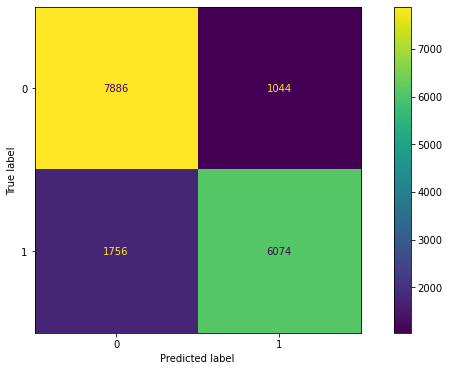

In [71]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_ALL_train, y_ALL_train, X_ALL_test, y_ALL_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ALL_test, y_ALL_test, values_format='d');

### Saving the model

In [72]:
model_name = '../raw_data/ALL_model.joblib'
    
save_model(nb_grid_search.best_estimator_, model_name)

model = get_model(model_name)

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [73]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.78
Precision: 0.85
f1: 0.81
--------------------------------------------------------------------------------


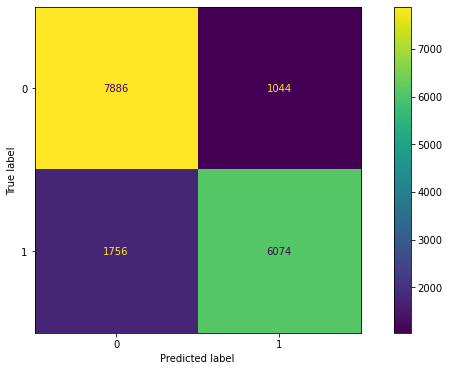

In [74]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_ALL_train, y_ALL_train, X_ALL_test, y_ALL_test)

plot_confusion_matrix(model, X_ALL_test, y_ALL_test, values_format='d');

### `ALL_model.joblib` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.88
Recall: 0.86
Precision: 0.92
f1: 0.89
--------------------------------------------------------------------------------


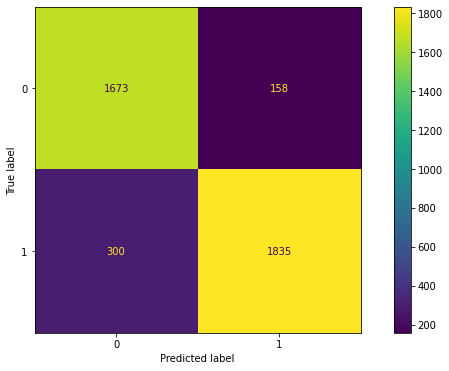

In [75]:
y_preds = model.predict(X_P_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P_test, y_preds)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `ALL_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.91
Recall: 0.72
Precision: 0.87
f1: 0.79
--------------------------------------------------------------------------------


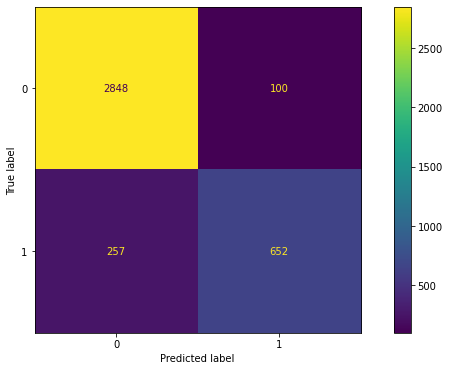

In [76]:
y_preds = model.predict(X_FNN_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN_test, y_preds)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `ALL_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/ALL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.98
Recall: 0.98
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------


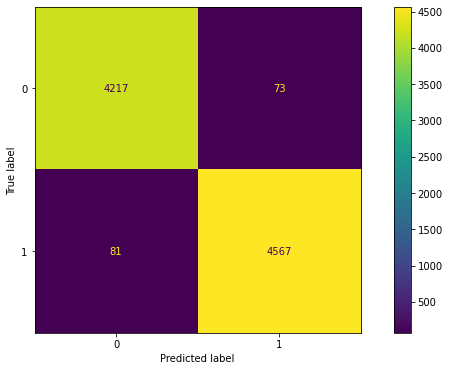

In [78]:
y_preds = model.predict(X_BIS_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS_test, y_preds)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

## `Alll`

### Preprocessing

In [79]:
vectorizer_ALLL = TfidfVectorizer()
X_ALLL_train_vec = vectorizer_ALLL.fit_transform(X_ALLL_train)
X_ALLL_test_vec = vectorizer_ALLL.transform(X_ALLL_test)

X_ALLL_train_vec_df = pd.DataFrame(X_ALLL_train_vec.toarray(), columns = vectorizer_ALLL.get_feature_names())

print('-'*80)
print(f"X_ALLL_train_vec shape: {X_ALLL_train_vec.shape}")
print(f"X_ALLL_test_vec shape: {X_ALLL_test_vec.shape}")
print('-'*80)
print(X_ALLL_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train_vec shape: (78954, 29862)
X_ALLL_test_vec shape: (19739, 29862)
--------------------------------------------------------------------------------
    aa  aaa  aaj  aaliyah  aap  aar  aardvark  aarogya  aaron  aarp  ...  вин  \
0  0.0  0.0  0.0      0.0  0.0  0.0       0.0      0.0    0.0   0.0  ...  0.0   
1  0.0  0.0  0.0      0.0  0.0  0.0       0.0      0.0    0.0   0.0  ...  0.0   
2  0.0  0.0  0.0      0.0  0.0  0.0       0.0      0.0    0.0   0.0  ...  0.0   
3  0.0  0.0  0.0      0.0  0.0  0.0       0.0      0.0    0.0   0.0  ...  0.0   
4  0.0  0.0  0.0      0.0  0.0  0.0       0.0      0.0    0.0   0.0  ...  0.0   

   контора  монако  пернелл  питт  принцессы  ради  сми  эллу  ḍozen  
0      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
1      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0    0.0  
2      0.0     0.0      0.0   0.0        0.0   0.0  0.0   0.0

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.79
Recall: 0.75
Precision: 0.80
f1: 0.77
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.80
Recall: 0.75
Precision: 0.81
f1: 0.78
--------------------------------------------------------------------------------


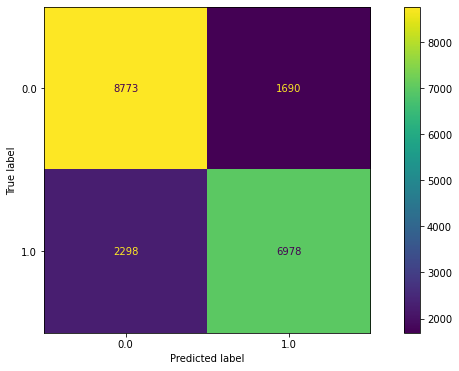

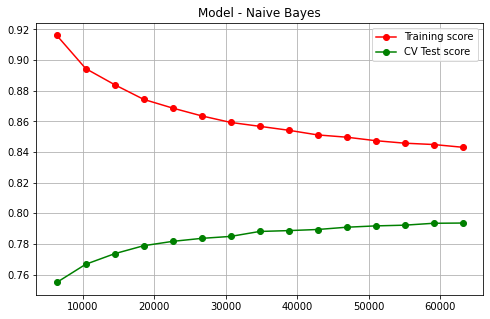

In [80]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_ALLL_train_vec, y_ALLL_train, X_ALLL_test_vec, y_ALLL_test)

plot_confusion_matrix(nb_model, X_ALLL_test_vec, y_ALLL_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_ALLL_train_vec, y_ALLL_train)

### Naive Bayes - Fine-Tuning

In [81]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_ALLL_train, y_ALLL_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 3)}
Best score: 0.8159687894303636
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.75
Precision: 0.84
f1: 0.79
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.75
Precision: 0.85
f1: 0.80
--------------------------------------------------------------------------------


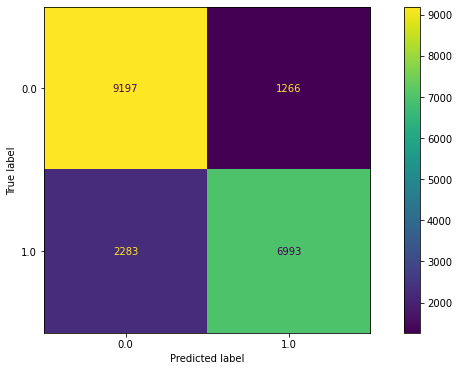

In [82]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_ALLL_train, y_ALLL_train, X_ALLL_test, y_ALLL_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ALLL_test, y_ALLL_test, values_format='d');

### Saving the model

In [83]:
model_name = '../raw_data/ALLL_model.joblib'
    
save_model(nb_grid_search.best_estimator_, model_name)

model = get_model(model_name)

--------------------------------------------------------------------------------
../raw_data/ALLL_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [84]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.75
Precision: 0.84
f1: 0.79
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.75
Precision: 0.85
f1: 0.80
--------------------------------------------------------------------------------


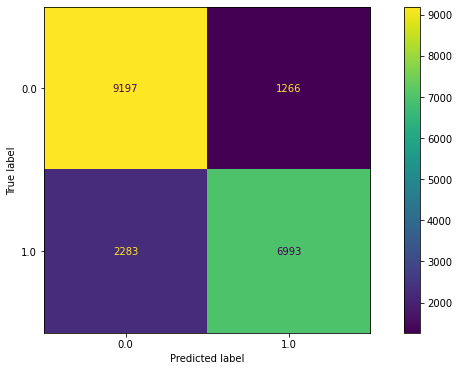

In [85]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_ALLL_train, y_ALLL_train, X_ALLL_test, y_ALLL_test)

plot_confusion_matrix(model, X_ALLL_test, y_ALLL_test, values_format='d');

### `ALLL_model.joblib` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
../raw_data/ALLL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.89
Recall: 0.86
Precision: 0.92
f1: 0.89
--------------------------------------------------------------------------------


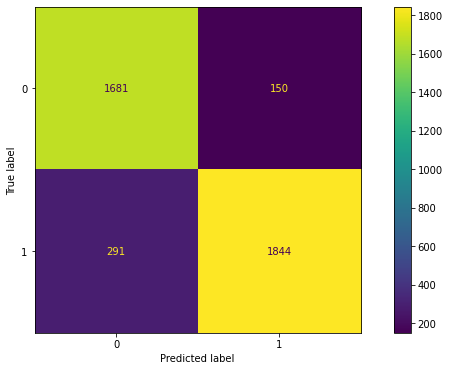

In [86]:
y_preds = model.predict(X_P_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_P_test, y_preds)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

### `ALLL_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
../raw_data/ALLL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.91
Recall: 0.73
Precision: 0.88
f1: 0.80
--------------------------------------------------------------------------------


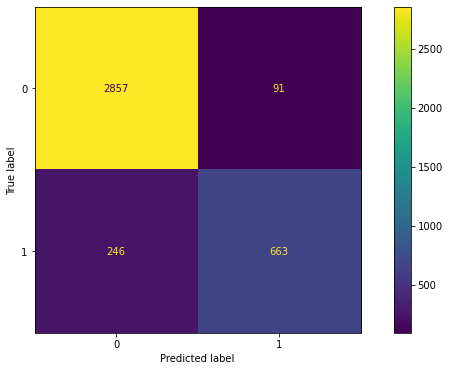

In [87]:
y_preds = model.predict(X_FNN_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_FNN_test, y_preds)

plot_confusion_matrix(model, X_FNN_test, y_FNN_test, values_format='d');

### `ALLL_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
../raw_data/ALLL_model.joblib - test scores: 
--------------------------------------------------------------------------------
Acc: 0.98
Recall: 0.98
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------


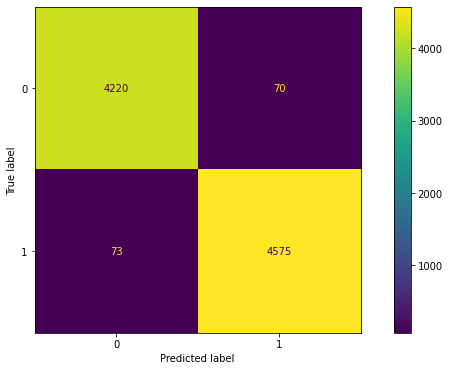

In [88]:
y_preds = model.predict(X_BIS_test)

print('-'*80)
print(f"{model_name} - test scores: ")
binary_metrics(y_BIS_test, y_preds)

plot_confusion_matrix(model, X_BIS_test, y_BIS_test, values_format='d');

## Summary

In [89]:
def get_summary(model_names, datas):

    X_data = [[X_P_test, X_FNN, X_BIS, X_all, X_alll],
              [X_P, X_FNN_test, X_BIS, X_all, X_alll],
              [X_P, X_FNN, X_BIS_test, X_all, X_alll],
              [X_P_test, X_FNN_test, X_BIS_test, X_ALL_test, X_ALLL_test],
              [X_P_test, X_FNN_test, X_BIS_test, X_ALL_test, X_ALLL_test]]

    y_data = [[y_P_test, y_FNN, y_BIS, y_all, y_alll],
              [y_P, y_FNN_test, y_BIS, y_all, y_alll],
              [y_P, y_FNN, y_BIS_test, y_all, y_alll],
              [y_P_test, y_FNN_test, y_BIS_test, y_ALL_test, y_ALLL_test],
              [y_P_test, y_FNN_test, y_BIS_test, y_ALL_test, y_ALLL_test]]

    model_list = []
    data_list = []
    acc_list = []
    recall_list = []
    prec_list = []
    f1_list = []
    
    for model_name, Xs, ys in zip(model_names, X_data, y_data):

        for data, X, y in zip(datas, Xs, ys):

#             print('-'*80)
#             print(model_name)
#             print(data)
#             print(X.shape)
#             print(y.shape)

            y_preds = get_model(model_name).predict(X)

            model_list.append(model_name)
            data_list.append(data)
            acc_list.append(np.round(accuracy_score(y, y_preds), 2))
            recall_list.append(np.round(recall_score(y, y_preds), 2))
            prec_list.append(np.round(precision_score(y, y_preds), 2))
            f1_list.append(np.round(f1_score(y, y_preds), 2))

    df = pd.DataFrame({'model': model_list, 
                   'data': data_list, 
                   'acc': acc_list,
                   'recall': recall_list, 
                   'prec': prec_list,
                   'f1': f1_list,
    })
    
    return df

In [92]:
model_names = ['../raw_data/P_model.joblib',
               '../raw_data/F_model.joblib', 
               '../raw_data/B_model.joblib', 
               '../raw_data/ALL_model.joblib',
               '../raw_data/ALLL_model.joblib']

datas = ['politifact', 'FakeNewsNET', 'Bisaillon', 'All', 'Alll']

df = get_summary(model_names, datas)
df.head(30)

,model,data,acc,recall,prec,f1
0,../raw_data/P_model.joblib,politifact,0.66,0.76,0.66,0.70
1,../raw_data/P_model.joblib,FakeNewsNET,0.29,0.94,0.25,0.39
2,../raw_data/P_model.joblib,Bisaillon,0.56,0.97,0.55,0.70
3,../raw_data/P_model.joblib,All,0.57,0.95,0.52,0.68
4,../raw_data/P_model.joblib,Alll,0.56,0.96,0.52,0.67
5,../raw_data/F_model.joblib,politifact,0.50,0.15,0.70,0.24
6,../raw_data/F_model.joblib,FakeNewsNET,0.83,0.49,0.71,0.58
7,../raw_data/F_model.joblib,Bisaillon,0.50,0.24,0.56,0.33
8,../raw_data/F_model.joblib,All,0.61,0.29,0.68,0.40
9,../raw_data/F_model.joblib,Alll,0.59,0.27,0.66,0.38


In [94]:
file_path = '../raw_data/ML_summary.csv'

df.to_csv(file_path, index=False)

## Prediction

In [106]:
model_name = '../raw_data/ALLL_model.joblib'

model = get_model(model_name)

In [107]:
fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [108]:
sample = [fake0, fake1, fake2, true0, true1, true2]
label = [1, 1, 1, 0, 0, 0]

X_sample_clean = [clean(text) for text in sample] 

y_preds = model.predict_proba(X_sample_clean)[:, 1]

print('-'*80)
print(y_preds)
print(f" Acc: {np.round(accuracy_score(label, model.predict(X_sample_clean)), 2)}")
print('-'*80)

--------------------------------------------------------------------------------
[0.45327945 0.34130389 0.56571172 0.51253854 0.34099169 0.26875223]
 Accuracy: 0.5
--------------------------------------------------------------------------------


In [ ]:
import eli5
from eli5.lime import TextExplainer

sample = clean(true2)

te = TextExplainer(random_state=42)
te.fit(sample, model.predict_proba)
te.show_prediction(target_names=['true', 'fake'])

## ELI5

In [ ]:
# ! pip install eli5

In [ ]:
# def print_prediction(doc):
#     y_pred = model.predict_proba([doc])[0]
#     for target, prob in zip(twenty_train.target_names, y_pred):
#         print("{:.3f} {}".format(prob, target))

# doc = twenty_test.data[0]
# print_prediction(doc)

In [ ]:
# import eli5
# from eli5.lime import TextExplainer

# te = TextExplainer(random_state=42)
# te.fit(X_sample_clean[0], model.predict_proba)
# te.show_prediction(target_names='fake')

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)

In [ ]:
print('-'*80)
print(f"train length: {len(twenty_test.data)}")
print(f"sample: {twenty_test.data[1]}")
print(f"target: {twenty_test.target[1]}")
print('-'*80)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

vec = TfidfVectorizer(min_df=3, stop_words='english',
                      ngram_range=(1, 2))

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

lsa = make_pipeline(vec, svd)

clf = SVC(C=150, gamma=2e-2, probability=True)
pipe = make_pipeline(lsa, clf)
pipe.fit(twenty_train.data, twenty_train.target)
pipe.score(twenty_test.data, twenty_test.target)

In [ ]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    for target, prob in zip(twenty_train.target_names, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = twenty_test.data[0]
print_prediction(doc)

In [ ]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)